In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pickle
import string

from scipy import signal

import matplotlib.pyplot as plt

In [3]:
code_dir = '../code'
sys.path.append(code_dir)

import config
from utils import get_label
from experiment import get_model_from_experiment

In [4]:
# text
plt.rcParams['text.usetex'] = True
plt.rcParams['pdf.fonttype'] = 42

# plotting
plt.rcParams['lines.linewidth'] = 0.75

In [5]:
def plot_crosscol(file_paths, ax, c0='k', T=200, bin_width=1e-4, xlim=None, **kw):
    kw = kw.copy()
    ts = []
    for file_path in file_paths:
        with open(file_path, 'rb') as tmp:
            data = pickle.load(tmp)
        ts.append(np.histogram(data['t_s'], bins=int(T/bin_width), range=(0, T))[0])
    cross = signal.correlate(ts[0], ts[1])
    cross = cross/cross.max()
    lags = signal.correlation_lags(len(ts[0]), len(ts[1])) * bin_width
    shift = lags[np.argmax(cross)]
    
    ax.plot(lags, cross, **kw)
    ylim = ax.get_ylim()
    c = kw.pop('c', 'k')
    ax.vlines([shift], *ylim, ls='--', color=c, **kw)
    ax.vlines([0], *ylim, ls='--', color=c0, **kw)
    ax.set_ylim(ylim)

    shift *= 1e3
    if bin_width >= 1e-3:
        shift = int(shift)
    if np.sign(shift) < 0:
        ha = 'right'
    else:
        ha  = 'left'
    ax.text(shift*1e-3 + .01 * np.sign(shift), .9, r'$' + str(shift) + r'\,{\rm ms}$', ha=ha, fontsize=fontsize, c=c)

    ax.set_xlim(xlim)

In [ ]:
# generate data
pc_ids = ['001', '002', '003']
# second example for id 001, because first example spikes irregulare
idxs = [1, 0, 0]

data_dir = '../data/posterior_check/'

for pc_id, pc_idx in zip(pc_ids, idxs):
    pre_fixes = ['posterio_check', pc_id, '1000s', 'just_noise']
    
    experiment_params = config.experiment['posterior_check'][pc_id]
    sbi_id = experiment_params['sbi_experiment_id']
    sbi_params = config.experiment['sbi'][sbi_id]
    
    
    file_path = os.path.join(data_dir, pc_id, 'simulation_results.p')
    with open(file_path, 'rb') as tmp:
        variables = pickle.load(tmp)
    x = variables['x']
    thetas = variables['theta']
    idx = np.argsort(abs(x - experiment_params['x_o']))[pc_idx]
    
    fixed_simulation_parameters = {
        'N': 1,
        't': '1000*second',
    }
    fixed_model_parameters = {
        'I1': '0.0*nA'
    }
    
    seed = 20221107
    
    m = get_model_from_experiment('sbi', experiment_id=sbi_id, results=thetas[idx], fixed_model_parameters=fixed_model_parameters, fixed_simulation_parameters=fixed_simulation_parameters, seed=seed)
    data = {
        't_s': m.get_variable('spikes')[0],
        'v': m.get_variable('v')[1],
        'I': m.get_variable('I')[1],
        'fixed_simulation_parameters': fixed_simulation_parameters,
        'fixed_model_parameters': fixed_model_parameters,
        'theta': thetas[idx],
    }
    file_str = '_'.join(pre_fixes + [str(pc_idx)]) + '.p'
    with open(os.path.join(data_dir, file_str), 'wb') as tmp:
        pickle.dump(data, tmp)

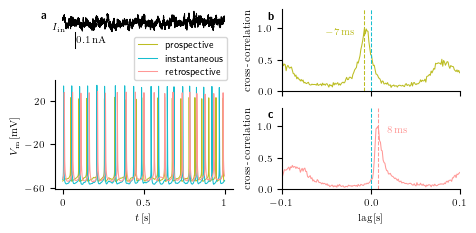

In [7]:
xlim = [-.05, .05]
bin_width = 1e-3

data_dir = '../data/posterior_check'
pc_ids = ['001', '002', '003']
pc_idxs = [1, 0, 0]
file_paths = {}
for pc_id, pc_idx in zip(pc_ids, pc_idxs):
    pre_fixes = ['posterio_check', pc_id, '1000s', 'just_noise']
    file_str = '_'.join(pre_fixes + [str(pc_idx)]) + '.p'
    file_paths[pc_id] = os.path.join(data_dir, file_str)

fontsize=7
subfigs_kw = {
    'wspace': -.075,
}
gridspec_kw = {
    'left': 0.225,
    'right': .95,
    'bottom': .175,
    'top': .975
}

plot_kw = {'lw': 0.75}

fsize = 3/4

fig = plt.figure(figsize=(fsize*6.3, fsize*3))
subfigs = fig.subfigures(1,2, **subfigs_kw)
# gridspec_kw['top'] = 0.95
ax_I, ax_v = subfigs[0].subplots(2, 1, height_ratios=[1, 2], gridspec_kw=gridspec_kw)
# gridspec_kw['top'] = 1
axs = subfigs[1].subplots(2, 1, gridspec_kw=gridspec_kw)

axs_ = [ax_I, axs[0], axs[1]]

labels = ['prospective', 'instantaneous', 'retrospective']

colors = [plt.colormaps['tab20'](i) for i in [16, 18, 7]]

for i_id, pc_id in enumerate(['001', '002', '003']):
    T = 1000

    with open(file_paths[pc_id], 'rb') as tmp:
        data = pickle.load(tmp)

    i_from = 5000000
    i_to = i_from + 10000

    
    i_from = 10000
    i_to = i_from + 20000
    t = np.arange(0, 1000, 1e-4)
    
    ax_v.plot(t[i_from:i_to], 1e3*data['v'][i_from:i_to], label=labels[i_id], c=colors[i_id], **plot_kw)

ax_I.plot(t[i_from:i_to], 1e9*data['I'][i_from:i_to], label=labels[i_id], c='k', **plot_kw)
ax_I.axis('off')

t_ = t[i_from:i_to][1500]
I_ = 1e9*data['I'][i_from:i_to][100]
dt = 1e-4
ax_I.plot([t_]*2, [I_ - 0.1, I_ - 0.2], c='k', **plot_kw)
ax_I.text(t_ + 0.02, I_ - 0.15, r'$0.1\,{\rm nA}$', size=fontsize, ha='left', va='center')

ax_I.text(i_from*dt+.025, I_*.85, r'$I_{\rm in}$', size=fontsize, ha='right', va='top')

cmap = plt.colormaps['tab10']
for i_row, pc_ids in enumerate([['001', '002'], ['003', '002']]):
    if i_row == 0:
        c = colors[0]
        gridspec_kw['top'] = .8
        gridspec_kw['bottom'] = 0.05
    else:
        c = colors[2]
        gridspec_kw['top'] = .95
        gridspec_kw['bottom'] = 0.2
    ax = axs[i_row]
    ax.set_ylim([0, 1.3])
    T = 1000
    
    tmp_paths = [file_paths[pc_id] for pc_id in pc_ids]
    plot_crosscol(tmp_paths, ax, T=T, bin_width=bin_width, xlim=xlim, c=c, c0=colors[1], **plot_kw)
    ax.tick_params(labelsize=fontsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if i_row == 0:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel(r'${\rm lag [s]}$', size=fontsize)
    ax.set_yticks([0, 0.5, 1])
    ax.set_xticks([-0.1, 0, 0.1])
    ax.set_ylabel(r'${\rm cross}\,$-$\,{\rm correlation}$', size=fontsize)

ylim = ax_I.get_ylim()
ax_I.set_ylim([0, ylim[1]])
ax_I.set_xticks([])
ax_I.set_ylabel(get_label('I'), size=fontsize)



ax_v.set_xticks([i_from*dt, (i_from + (i_to - i_from)/2) * dt, i_to * dt], ['$0$', '$0.5$', '$1$'])
ax_v.set_yticks([-60, -20, 20])
ax_v.set_ylabel(get_label('v'), size=fontsize)
ax_v.set_xlabel(get_label('t'), size=fontsize)

for ax in [ax_I, ax_v]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=fontsize)
    

subfigs[0].align_ylabels([ax_I, ax_v])


ax_v.legend(fontsize=fontsize, loc='upper right', bbox_to_anchor=(.97,1.4), borderaxespad=0)# loc=(1,1))

i = 0
for ax in axs_:
    ax.tick_params(labelsize=fontsize)
    p_ = r'${\textbf ' + string.ascii_lowercase[i] + '}$'
    ax.text(-.075, .975, p_, fontsize=8, transform=ax.transAxes, va='top', ha='left', weight='bold')
    i += 1

save_str = 'Fig-x_cross_correlogram_WIP_I_in'
# plt.savefig(save_str + '.svg', pad_inches=0.1, dpi=300)
# plt.savefig(save_str + '.pdf', pad_inches=0.1, dpi=300, facecolor='w')